In [15]:
#######################################
# CS 424 - Project 3
# Kevin Kowalski
# Samuel Kajah
# Vijay Vemu
#######################################
#
# This file contains the code to clean
# the original data set. It outputs
# the necessary plots and updated data
# set to be used by shiny.
#
# This file was used for testing and 
# plotting before using RStudio for a
# dashboard.
#
#######################################

In [16]:
# import libraries
library(comprehenr)
library(dplyr)
library(ggplot2)
library(hashmap)
library(lubridate)
library(stringr)
library(tidyverse)

In [121]:
# read in the combined RDS file
data <- readRDS(file = "combined_data.rds")

# LEAVE COMMENTED, UNLESS YOU NEED TO REMAKE FILE
# keywords table only for movies found in combined data table
#keywords_subset <- subset(df_keywords, movie %in% data$movie)
#write.csv(keywords_subset, file = 'keywords_subset.csv')

# read in the subsetted keywords CSV file
keywords_subset = read.csv('keywords_subset.csv')

In [113]:
# output number of entries in data
total_data <- count(data)
print(paste0("---- data, n=", total_data))
unique_films <- length(unique(data$movie))
print(paste0("---- unique movies, n=", unique_films))

[1] "---- data, n=334427"
[1] "---- unique movies, n=36596"


In [25]:
# get list of movies where none is duplicated (used for times where you only want to account for a movie once, such as runtime average)
unique_movies <- subset(data, !duplicated(subset(data, select = movie)))

In [26]:
# preview the top 5 rows
head(data, 5)

# get a random sample of 5 rows
sample_n(data, 5)

,movie,year,month,genre,runtime,rating
,<chr>,<int>,<fct>,<fct>,<dbl>,<fct>
214,#FollowFriday (2016),2016,September,Thriller,90,USA:Unrated
698,$ (1971),1971,December,Comedy,121,USA:R
700,$ (1971),1971,December,Crime,121,USA:R
702,$ (1971),1971,December,Drama,121,USA:R
714,$10 Raise (1935),1935,May,Comedy,70,USA:Approved


movie,year,month,genre,runtime,rating
<chr>,<int>,<fct>,<fct>,<dbl>,<fct>
Extraction (2015/II),2015,December,Action,82,USA:R
Stranger Than Paradise (1984),1984,August,Comedy,89,USA:R
Zui quan (1978),1978,October,Comedy,111,USA:PG-13
Montana Moon (1930),1930,March,Musical,89,USA:Approved
Post Impact (2004),2004,June,Thriller,90,USA:R


In [27]:
# get min and max years
min_year_all <- min(data$year)
max_year_all <- max(data$year)
print(paste0("---- years range from: ", min_year_all, "-", max_year_all))

[1] "---- years range from: 1912-2019"


In [28]:
# get min and max decades
min_decade_all <- floor(min(data$year) / 10) * 10
max_decade_all <- floor(max(data$year) / 10) * 10
print(paste0("---- decades range from: ", min_decade_all, "-", max_decade_all))

[1] "---- decades range from: 1910-2010"


In [29]:
# get min and max runtimes
min_runtime_all <- min(data$runtime)
max_runtime_all <- max(data$runtime)
print(paste0("---- runtimes range from: ", min_runtime_all, "-", max_runtime_all, " minutes"))

[1] "---- runtimes range from: 60-453 minutes"


In [30]:
############## COUNT/DISTRIBUTION TABLES BELOW ##############

In [137]:
# function to get a count of movies from each year as a table (same as above)
number_films_per_year = function(table) {
    
    # create empty dataframe of all years in range from calculated min to max
    all_years <- data.frame(formatC(min_year_all:max_year_all, width = 2), 0)
    names(all_years)[1] <- "year"
    names(all_years)[2] <- "count"
    all_years$year <- c(min_year_all:max_year_all)
    
    # make dataframe of available years and their frequency
    by_year <- table %>% group_by(year) %>% summarize(count = n())
    
    # join the counts into the full range of years dataframe
    by_year <- full_join(all_years, by_year, by = "year")
    by_year[is.na(by_year)] <- 0
    by_year$count.x <- NULL
    names(by_year)[2] <- "count"
    
    # output info
    total_films = as.numeric(sum(by_year$count))
    print(paste0("---- total counted= ", total_films))
    unique_years = as.numeric(count(by_year))
    print(paste0("---- unique years= ", unique_years))
    
    # return the table of counts per year
    by_year
}

# function to get a count of movies from each decade as a table
number_films_per_decade = function(table) {
    
    # create empty dataframe of each decade in range from calculated min to max
    all_decades <- data.frame(formatC(1:((max_decade_all - min_decade_all) / 10 + 1), width = 2), 0)
    names(all_decades)[1] <- "decade"
    names(all_decades)[2] <- "count"
    all_decades$decade <- seq(from = min_decade_all, to = max_decade_all, by = 10)
    
    # INEFFICIENT NESTED LOOP, IDEALLY A GROUP_BY OR SOMETHING BETTER
    # loop through each movie in given table
    for (row in 1:as.numeric(count(table))) {
        
        # get the current movie's decade it belongs to
        curr_decade = floor(table$year[row] / 10) * 10
        
        # loop through each decade
        for (i in 1:as.numeric(count(all_decades))) {
            
            # increment the decade count for found decade
            if (curr_decade == all_decades$decade[i]) {
                all_decades$count[i] <- all_decades$count[i] + 1
                break
            }
        }
    }
    
    # output info
    total_films = as.numeric(sum(all_decades$count))
    print(paste0("---- total counted= ", total_films))
    unique_decades = as.numeric(count(all_decades))
    print(paste0("---- unique decades= ", unique_decades))
    
    # return the table of counts per decade
    all_decades
}

# function to get a count of movies from each month as a table
number_films_per_month = function(table) {
    
    # get a count of movies from each month
    by_month <- table %>% group_by(month) %>% summarize(count = n())

    # reorder months to be in order
    by_month$month <- factor(by_month$month, levels = c("January", "February", "March", "April", "May", "June", "July", "August", "September", "October", "November", "December"))
    by_month <- by_month[order(by_month$month), ]

    # output info
    by_month
    print(paste0("---- total counted= ", sum(by_month$count)))
    unique_months = as.numeric(count(by_month))
    print(paste0("---- unique months= ", unique_months))
    
    # return the table of counts per month
    by_month
}

# function to get a distribution of runtimes as a table
distribution_of_runtimes = function(table) {
    
    # create empty dataframe of all runtimes in range from min to max
    all_runtimes <- data.frame(formatC(min_runtime_all:max_runtime_all, width = 2), 0)
    names(all_runtimes)[1] <- "runtime"
    names(all_runtimes)[2] <- "count"
    all_runtimes$runtime <- c(min_runtime_all:max_runtime_all)

    # make dataframe of available runtimes and their frequency
    by_runtime <- table %>% group_by(runtime) %>% summarize(count = n())

    # join the counts into the full range of years dataframe
    by_runtime <- full_join(all_runtimes, by_runtime, by = "runtime")
    by_runtime[is.na(by_runtime)] <- 0
    by_runtime$count.x <- NULL
    names(by_runtime)[2] <- "count"

    # output info
    head(by_runtime, 10)
    print(paste0("---- total counted= ", sum(by_runtime$count)))
    unique_runtimes = as.numeric(count(by_runtime))
    print(paste0("---- unique runtimes= ", unique_runtimes))
    
    # return the distribution of runtimes
    by_runtime
}

# function to get a distribution of certificates as a table
distribution_of_certificates = function(table) {
    
    # get a distribution of certificate
    by_certificates <- table %>% group_by(rating) %>% summarize(count = n())

    # output info
    print(paste0("---- total counted= ", sum(by_certificates$count)))
    unique_certificates = as.numeric(count(by_certificates))
    print(paste0("---- unique certificates= ", unique_certificates))
    
    # return the distribution of certificates
    by_certificates
}

# function to get a distribution of genres as a table
distribution_of_genres = function(table) {
    
    # get a distribution of genres
    by_genre <- table %>% group_by(genre) %>% summarize(count = n())

    # output info
    print(paste0("---- total counted= ", sum(by_genre$count)))
    unique_genres = as.numeric(count(by_genre))
    print(paste0("---- unique genres= ", unique_genres))
    
    # return the distribution of genres
    by_genre
}

# function to get a distribution of top n keywords as a table
distribution_of_keywords = function(table, n) {

    # get a distribution of top n keywords
    by_keywords <- table %>% group_by(keyword) %>% summarize(count = n())

    # output info
    by_keywords <- top_n(by_keywords, n) %>% arrange(desc(count))
    print(paste0("---- total counted= ", sum(by_keywords$count)))
    unique_keywords = as.numeric(count(by_keywords))
    print(paste0("---- unique keywords= ", unique_keywords))
    
    # return the distribution of top n keywords
    by_keywords
}


In [32]:
# get a count of movies from each year (for entire data (of unique movies))
by_year <- number_films_per_year(unique_movies)
sample_n(by_year, 5)

[1] "---- total counted= 36596"
[1] "---- unique years= 108"


year,count
<int>,<int>
2012,809
1923,15
2015,791
1984,306
1947,320


In [33]:
# get a count of movies from each decade (for entire data (of unique movies), takes a minute)
by_decade <- number_films_per_decade(unique_movies)
by_decade

[1] "---- total counted= 36596"
[1] "---- unique decades= 11"


decade,count
<dbl>,<dbl>
1910,34
1920,494
1930,3031
1940,3049
1950,2475
1960,1583
1970,3517
1980,3754
1990,4916


In [34]:
# get rows for a movie by partial name (can exclude year from its name)
# lots of movies have differing release months for some reason
# this SHOULD output 3 rows, 1 for each genre but many release months prevents this :(
jw2 <- data[str_detect(data$movie, "John Wick: Chapter 2"), ]
jw2

,movie,year,month,genre,runtime,rating
,<chr>,<int>,<fct>,<fct>,<dbl>,<fct>
1119397,John Wick: Chapter 2 (2017),2017,January,Action,122,USA:R
1119398,John Wick: Chapter 2 (2017),2017,February,Action,122,USA:R
1119462,John Wick: Chapter 2 (2017),2017,March,Action,122,USA:R
1119465,John Wick: Chapter 2 (2017),2017,April,Action,122,USA:R
1119466,John Wick: Chapter 2 (2017),2017,May,Action,122,USA:R
1119468,John Wick: Chapter 2 (2017),2017,July,Action,122,USA:R
1119469,John Wick: Chapter 2 (2017),2017,January,Crime,122,USA:R
1119470,John Wick: Chapter 2 (2017),2017,February,Crime,122,USA:R
1119534,John Wick: Chapter 2 (2017),2017,March,Crime,122,USA:R


In [35]:
# !!!
# since most movies have several months/genres as listed above, the leftover month
# from the unique_films table might not be correct so the months table below is skewed
# !!!

# get a count of movies from each month (for entire data (of unique movies))
by_month <- number_films_per_month(unique_movies)
by_month

[1] "---- total counted= 36596"
[1] "---- unique months= 12"


month,count
<fct>,<int>
January,3150
February,2511
March,3105
April,3082
May,3485
June,2651
July,2410
August,2921
September,4453


In [36]:
# get a distribution of runtimes
by_runtime <- distribution_of_runtimes(unique_movies)
sample_n(by_runtime, 5)

[1] "---- total counted= 36596"
[1] "---- unique runtimes= 395"


runtime,count
<dbl>,<dbl>
261,1
303,1
280,2
248,3
147,17


In [37]:
# get a distribution of certificate
by_certificates <- distribution_of_certificates(unique_movies)
by_certificates

[1] "---- total counted= 36596"
[1] "---- unique certificates= 12"


rating,count
<fct>,<int>
USA:(Banned),1
USA:12,4
USA:AO,3
USA:Approved,6604
USA:G,1175
USA:GP,186
USA:Open,9
USA:Passed,2776
USA:PG,4418


In [38]:
# get a distribution of genres
by_genre <- distribution_of_genres(unique_movies)
by_genre

[1] "---- total counted= 36596"
[1] "---- unique genres= 22"


genre,count
<fct>,<int>
Action,6226
Adventure,2399
Animation,294
Biography,1172
Comedy,9399
Crime,2834
Documentary,1255
Drama,8243
Family,161


In [39]:
# get a distribution of top n keywords
n = 10
by_keywords <- distribution_of_keywords(keywords_subset, n)
by_keywords

ERROR: Error in eval(lhs, parent, parent): object 'keywords_subset' not found


In [53]:
############## AVERAGES BELOW ##############

In [54]:
# get average films per year, month, and average runtime

# average fims per year: sum of films divided by total years observed
#avg_per_year = trunc(total_films / unique_years)
unique_years = as.numeric(count(by_year))
avg_per_year = trunc(unique_films / unique_years)
print(paste0("---- avg films per year= ", avg_per_year))

# average films per month: sum of films each month, each sum divided by total years observed; then average these results
unique_months = as.numeric(count(by_month))
avg_by_month <- by_month
avg_by_month$count <- by_month$count / unique_years
names(avg_by_month)[2] <- "average"
avg_per_month = trunc(as.numeric(sum(avg_by_month$average) / unique_months))
print(paste0("---- avg films per month= ", avg_per_month))
avg_by_month

# average runtime: sum of each runtime divided by total runtime observations
avg_runtime = trunc(mean(unique_movies$runtime))
print(paste0("---- avg runtime= ", avg_runtime))

[1] "---- avg films per year= 338"
[1] "---- avg films per month= 28"


month,average
<fct>,<dbl>
January,29.16667
February,23.25000
March,28.75000
April,28.53704
May,32.26852
June,24.54630
July,22.31481
August,27.04630
September,41.23148


[1] "---- avg runtime= 95"


In [55]:
############## CHOOSE YEAR OR DECADE ##############

In [56]:
# get items by year
selected_year = 2011

# USE THIS ONE TO FETCH MOVIES BY YEAR FROM THEIR NAME (I noticed some movies have a different year than in the name, but possibly not in this combined table)
# movie year found in movie name i.e. "{Title} (2014)" or "{Title} (2014/I)", extract year via pattern matching because year column is inaccurate for some reason
#regex_year = paste0("\\(", selected_year, "\\)|\\(", selected_year, "\\/")
#movies_in_selected_year <- subset(data, grepl(regex_year, movie))

# fetch the movies by the selected year
movies_in_selected_year <- subset(data, year == selected_year)

# output a sample of movies found for given year
sample_n(movies_in_selected_year, 10)

movie,year,month,genre,runtime,rating
<chr>,<int>,<fct>,<fct>,<dbl>,<fct>
Real Steel (2011),2011,October,Drama,127,USA:PG-13
Paul (2011),2011,May,Sci-Fi,104,USA:R
Bridesmaids (2011/I),2011,August,Comedy,125,USA:R
Rio (2011),2011,December,Comedy,96,USA:G
Pina (2011),2011,April,Documentary,103,USA:PG
Some Guy Who Kills People (2011),2011,December,Crime,97,USA:R
"Si tu meurs, je te tue (2011)",2011,March,Drama,95,USA:R
Xin hai ge ming (2011),2011,October,Adventure,121,USA:R
Winnie the Pooh (2011),2011,August,Family,63,USA:G


In [57]:
# get items by decade (where decades are in format of 1990, 2000, 2010, etc... for next 9 years, i.e. 1990-1999, 2000-2009, etc..)
selected_decade = 2010

# USE THIS ONE TO FETCH MOVIES BY YEAR FROM THEIR NAME
# movie year found in movie name i.e. "{Title} (2014)" or "{Title} (2014/I)", extract decade via pattern matching for decade + 9
#regex_decade = paste0("\\(", selected_decade / 10, "[0-9]\\)|\\(", selected_decade / 10, "[0-9]\\/")
#movies_in_selected_decade <- subset(data, grepl(regex_decade, movie))

# fetch the movies by the selected year
movies_in_selected_decade <- subset(data, year >= selected_decade & year < selected_decade + 10)

# output a sample of movies found for given year
sample_n(movies_in_selected_decade, 10)

movie,year,month,genre,runtime,rating
<chr>,<int>,<fct>,<fct>,<dbl>,<fct>
The Girl in the Photographs (2015),2015,November,Horror,95,USA:R
Eden (2014/II),2014,November,Music,131,USA:R
American Weightlifting (2013),2013,November,History,118,USA:Unrated
A Perfect Day (2015),2015,September,Drama,106,USA:R
Life After Beth (2014),2014,July,Horror,89,USA:R
Season of the Witch (2011),2011,July,Action,95,USA:PG-13
Appleseed Alpha (2014),2014,July,Sci-Fi,93,USA:PG-13
The Whole Truth (2016),2016,June,Drama,94,USA:R
The Desert of Forbidden Art (2010),2010,April,Adventure,80,USA:PG


In [58]:
############## CHOOSE GENRE ##############

In [59]:
# genre input is comma separated string list
selected_genres = "comedy, Drama , fake_test, doCumenTarY, "

# split genres input to individual inputs
genres <- unlist(strsplit(selected_genres, ","))

# retrieve first genre as a "base"
condition <- paste0("str_to_lower(str_trim(genres[1])) == str_to_lower(genre) ")

# if more than 1 genres provided...
if (length(genres) > 1) {
    
    # then build conditional string for each one after "base"
    for (i in 2:length(genres)) {
        
        # make a new condition with the current genre, being sure to ignore case and trim the input
        next_condition <- paste0("| str_to_lower(str_trim(genres[", i, "])) == str_to_lower(genre) ")
        
        # add the new condition onto the current list of conditions
        condition <- paste(condition, next_condition, sep = "")
    }
}

# movie genre found in genre column, just fetch it by parsing the condition from above
movies_in_selected_genre <- subset(data, eval(parse(text = condition)))

# output a sample of movies found for given genre(s)
sample_n(movies_in_selected_genre, 10)

movie,year,month,genre,runtime,rating
<chr>,<int>,<fct>,<fct>,<dbl>,<fct>
"Si tu meurs, je te tue (2011)",2011,March,Drama,90,USA:R
The Eyes of Tammy Faye (2000),2000,January,Documentary,79,USA:PG-13
Birch Interval (1976),1976,May,Drama,104,USA:PG
Smoke (1995),1995,June,Drama,112,USA:R
Mujang haeje (1975),1975,June,Drama,114,USA:R
L'amant (1992),1992,June,Drama,116,USA:R
Heavenly Bodies (1984),1984,December,Drama,89,USA:R
Support Your Local Gunfighter (1971),1971,October,Comedy,91,USA:G
The Killer Is Loose (1956),1956,November,Drama,73,USA:Approved


In [60]:
# number of films released in selected genre
number_in_genre <- length(unique(movies_in_selected_genre$movie))
print(paste0("---- films in genre= ", number_in_genre))

[1] "---- films in genre= 27448"


In [61]:
# table above can have duplicate movies due to movies having multiple genres or months
# get a subset of those movies where a movie only appears once
unique_movies_in_genre <- subset(movies_in_selected_genre, !duplicated(subset(movies_in_selected_genre, select = movie)))

# table of "number of films released in that genre each year" (total_counted value should match number_in_x value)
films_per_year_by_selected_genre <- number_films_per_year(unique_movies_in_genre)

# output a sample of 5 rows
sample_n(films_per_year_by_selected_genre, 5)

[1] "---- total counted= 27448"
[1] "---- unique years= 108"


year,count
<int>,<dbl>
1956,135
1971,280
1966,91
1965,81
1921,12


In [62]:
# get "percentage of films released in that genre each year"

# add total films per year to table and calculuate percentage
films_per_year_by_selected_genre$total <- by_year$count
films_per_year_by_selected_genre$percent <- (films_per_year_by_selected_genre$count / by_year$count) * 100

# output a sample of 5 rows
sample_n(films_per_year_by_selected_genre, 5)

year,count,total,percent
<int>,<dbl>,<int>,<dbl>
1985,272,350,77.71429
2010,580,769,75.42263
2017,364,506,71.93676
1966,91,150,60.66667
1950,199,311,63.98714


In [63]:
# table of "number of films released in that genre each decade" (total_counted value should match number_in_x value)
films_per_decade_by_selected_genre <- number_films_per_decade(unique_movies_in_genre)

# output a sample of 5 rows
sample_n(films_per_decade_by_selected_genre, 5)

[1] "---- total counted= 27448"
[1] "---- unique decades= 11"


decade,count
<dbl>,<dbl>
1910,23
1950,1549
1930,2379
1990,3760
2010,4634


In [64]:
# get "percentage of films released in that genre each decade"

# add total films per decade to table and calculuate percentage
films_per_decade_by_selected_genre$total <- by_decade$count
films_per_decade_by_selected_genre$percent <- (films_per_decade_by_selected_genre$count / by_decade$count) * 100

# show output
films_per_decade_by_selected_genre

decade,count,total,percent
<dbl>,<dbl>,<dbl>,<dbl>
1910,23,34,67.64706
1920,394,494,79.75709
1930,2379,3031,78.48895
1940,2288,3049,75.04100
1950,1549,2475,62.58586
1960,1135,1583,71.69931
1970,2613,3517,74.29628
1980,2758,3754,73.46830
1990,3760,4916,76.48495


In [65]:
# table of "number of films released in that genre each month" (total_counted value should match number_in_x value)
films_per_month_by_selected_genre <- number_films_per_month(unique_movies_in_genre)

# output a sample of 5 rows
sample_n(films_per_month_by_selected_genre, 5)

[1] "---- total counted= 27448"
[1] "---- unique months= 12"


month,count
<fct>,<int>
August,2129
June,1971
May,2673
September,3574
December,1988


In [66]:
# get "percentage of films released in that genre each month"

# add total films per month to table and calculuate percentage
films_per_month_by_selected_genre$total <- by_month$count
films_per_month_by_selected_genre$percent <- (films_per_month_by_selected_genre$count / by_month$count) * 100

# show output
films_per_month_by_selected_genre

month,count,total,percent
<fct>,<int>,<int>,<dbl>
January,2501,3150,79.39683
February,1906,2511,75.90601
March,2293,3105,73.84863
April,2289,3082,74.26995
May,2673,3485,76.70014
June,1971,2651,74.34930
July,1645,2410,68.25726
August,2129,2921,72.88600
September,3574,4453,80.26050


In [67]:
# table of "distribution of running times of films in that genre" (total_counted value should match number_in_x value)
distribution_runtimes_by_selected_genre <- distribution_of_runtimes(unique_movies_in_genre)

# output a sample of 5 rows
sample_n(distribution_runtimes_by_selected_genre, 5)

[1] "---- total counted= 27448"
[1] "---- unique runtimes= 395"


runtime,count
<dbl>,<dbl>
416,0
161,6
375,0
159,6
450,0


In [68]:
# table of "distribution of certificates in that genre" (total_counted value should match number_in_x value)
distribution_certificates_by_selected_genre <- distribution_of_certificates(unique_movies_in_genre)

# output a sample of 5 rows
sample_n(distribution_certificates_by_selected_genre, 5)

[1] "---- total counted= 27448"
[1] "---- unique certificates= 12"


rating,count
<fct>,<int>
USA:PG,3518
USA:Unrated,2268
USA:R,10293
USA:Approved,4800
USA:PG-13,3505


In [135]:
# table of "distribution of top n keywords in that genre"

# keywords table only for movies found in selected_genre
keywords_subset_for_genre <- subset(keywords_subset, movie %in% movies_in_selected_genre$movie)

top_N = 10
distribution_keywords_by_selected_genre <- distribution_of_keywords(keywords_subset_for_genre, top_N)

# output a sample of 10 rows
sample_n(distribution_keywords_by_selected_genre, 10)

Selecting by count



[1] "---- total counted= 40280"
[1] "---- unique keywords= 10"


keyword,count
<fct>,<int>
death,3601
independent-film,6517
father-son-relationship,3592
female-nudity,3792
cigarette-smoking,3521
murder,5012
based-on-novel,3612
father-daughter-relationship,3152
husband-wife-relationship,4239


In [124]:
############## CHOOSE KEYWORD ##############

In [140]:
# keyword input is comma separated string list
selected_keywords = "fight, cat-and-mouse , fake_test, shOtguN, "

# split keyword input to individual inputs
keywords <- unlist(strsplit(selected_keywords, ","))

# retrieve first keyword as a "base"
condition <- paste0("str_to_lower(str_trim(keywords[1])) == str_to_lower(keyword) ")

# if more than 1 keywords provided...
if (length(keywords) > 1) {
    
    # then build conditional string for each one after "base"
    for (i in 2:length(keywords)) {
        
        # make a new condition with the current keyword, being sure to ignore case and trim the input
        next_condition <- paste0("| str_to_lower(str_trim(keywords[", i, "])) == str_to_lower(keyword) ")
        
        # add the new condition onto the current list of conditions
        condition <- paste(condition, next_condition, sep = "")
    }
}

# movie keyword found in keyword column, just fetch it by parsing the condition from above
movies_in_selected_keywords <- subset(keywords_subset, eval(parse(text = condition)))

# output a sample of movies found for given keyword(s)
sample_n(movies_in_selected_keywords, 10)

X,movie,keyword
<int>,<fct>,<fct>
2761215,Stronger (2017/I),fight
1040352,Fong sai yuk 2 (1993),fight
3316450,The Tenants (2005),fight
3027534,The Four Feathers (2002),fight
1856388,Magnum Force (1973),shotgun
2836480,Te wu mi cheng (2001),fight
2957774,The Courier (2012),fight
2789204,Surviving the Game (1994),fight
1285384,Hollywood Cop (1987),fight


In [126]:
#
#
# repeat code similarily as found in CHOOSE GENRE section
#
#

In [127]:
############## CHOOSE CERTIFICATE ##############

In [128]:
# certificate input is comma separated string list
selected_certificates = "USA:Pg-13, USA:UnRateD , USA:fake_test, USA:, "

# split certificate input to individual inputs
certificates <- unlist(strsplit(selected_certificates, ","))

# retrieve first certificate as a "base"
condition <- paste0("str_to_lower(str_trim(certificates[1])) == str_to_lower(rating) ")

# if more than 1 certificates provided...
if (length(certificates) > 1) {
    
    # then build conditional string for each one after "base"
    for (i in 2:length(certificates)) {
        
        # make a new condition with the current certificate, being sure to ignore case and trim the input
        next_condition <- paste0("| str_to_lower(str_trim(certificates[", i, "])) == str_to_lower(rating) ")
        
        # add the new condition onto the current list of conditions
        condition <- paste(condition, next_condition, sep = "")
    }
}

# movie certificate found in certificate column, just fetch it by parsing the condition from above
movies_in_selected_certificates <- subset(data, eval(parse(text = condition)))

# output a sample of movies found for given certificate(s)
sample_n(movies_in_selected_certificates, 10)

movie,year,month,genre,runtime,rating
<chr>,<int>,<fct>,<fct>,<dbl>,<fct>
Serving Sara (2002),2002,October,Romance,99,USA:PG-13
Mon roi (2015),2015,May,Romance,124,USA:Unrated
The Maze Runner (2014),2014,October,Thriller,113,USA:PG-13
The Forest (2016/I),2016,April,Horror,93,USA:PG-13
Supernova (2000/I),2000,October,Thriller,91,USA:PG-13
Pray for Rain (2017),2017,August,Drama,92,USA:PG-13
De-Lovely (2004),2004,May,Drama,125,USA:PG-13
The Love Witch (2016),2016,June,Comedy,120,USA:Unrated
Hancock (2008),2008,September,Crime,102,USA:PG-13


In [129]:
#
#
# repeat code similarily as found in CHOOSE GENRE section
#
#

In [130]:
############## CHOOSE RUNTIME ##############

In [131]:
# runtime input is range from min to max
runtime_min = 60
runtime_max = 120

# movie runtime found in runtime column, just fetch it and compare the inputs
movies_in_selected_runtimes <- subset(data, runtime_min <= runtime & runtime_max >= runtime)

# output a sample of movies found for given runtime range
sample_n(movies_in_selected_runtimes, 10)

movie,year,month,genre,runtime,rating
<chr>,<int>,<fct>,<fct>,<dbl>,<fct>
New Jack City (1991),1991,November,Thriller,97,USA:R
Phantasm III: Lord of the Dead (1994),1994,February,Sci-Fi,91,USA:R
La folie des grandeurs (1971),1971,December,History,108,USA:PG
Burn Your Maps (2016),2016,December,Adventure,102,USA:PG-13
Kings (2017),2017,November,Thriller,92,USA:R
A Boy Named Charlie Brown (1969),1969,December,Animation,88,USA:G
The Hideous Sun Demon (1958),1958,August,Sci-Fi,74,USA:Unrated
Harry and the Hendersons (1987),1987,June,Family,110,USA:PG
Cursed (2005),2005,March,Horror,99,USA:R


In [132]:
#
#
# repeat code similarily as found in CHOOSE GENRE section
#
#

In [133]:
############## PLOTS ##############

[1] "---- total counted= 36596"
[1] "---- unique years= 108"


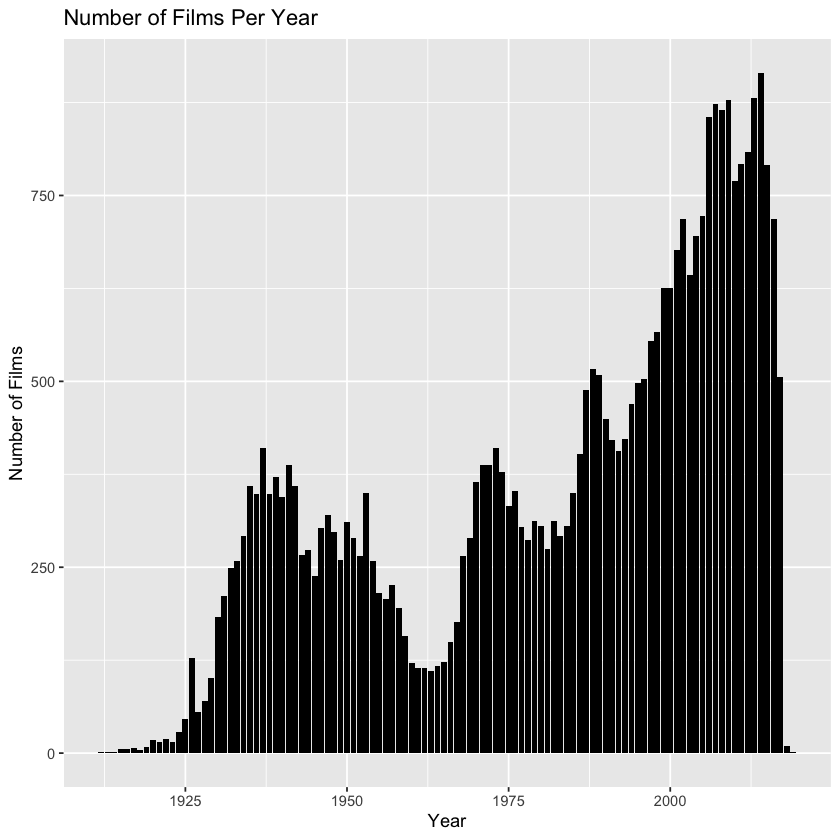

In [114]:
## Bar chart for films released per year## 

films_per_year_graph = number_films_per_year(unique_movies)
ggplot(films_per_year_graph, aes(x=year, y=count)) +
  geom_bar(stat = "identity", fill = "black") + labs(title = "Number of Films Per Year", x = "Year", y = "Number of Films")

[1] "---- total counted= 36596"
[1] "---- unique months= 12"


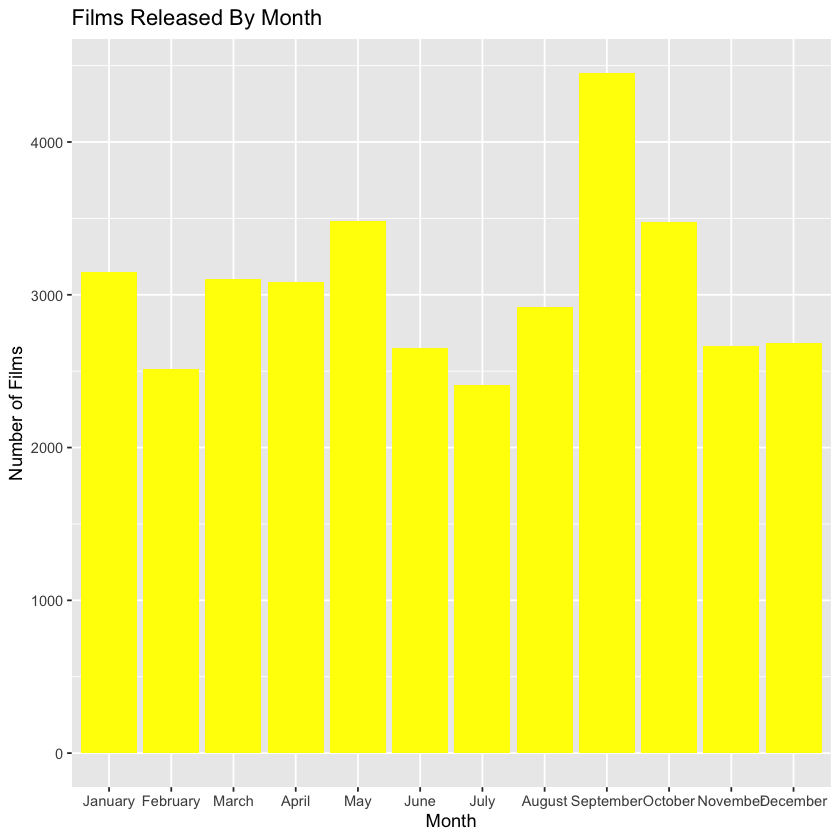

In [115]:
## Bar chart for films released per month## 
films_per_month_graph = number_films_per_month(unique_movies)

ggplot(films_per_month_graph, aes(x=month, y=count)) +
  geom_bar(stat = "identity", fill = "yellow") + labs(title = "Films Released By Month", x = "Month", y = "Number of Films")

In [96]:
## Bar chart for distribution runtimes##


[1] "---- total counted= 36596"
[1] "---- unique genres= 22"


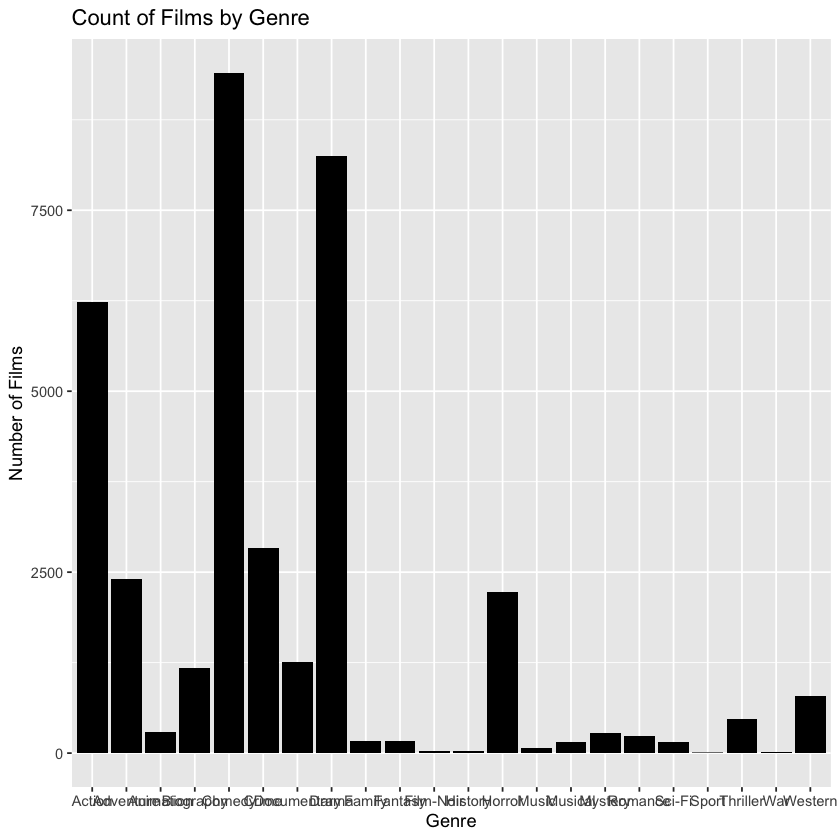

In [116]:
## Bar chart for distribution of genres ##

genres_graph = distribution_of_genres(unique_movies)

ggplot(genres_graph, aes(x= genre, y=count)) + geom_bar(stat = "identity", fill = "black") + labs(title = "Count of Films by Genre", x = "Genre", y = "Number of Films")

[1] "---- total counted= 36596"
[1] "---- unique certificates= 12"


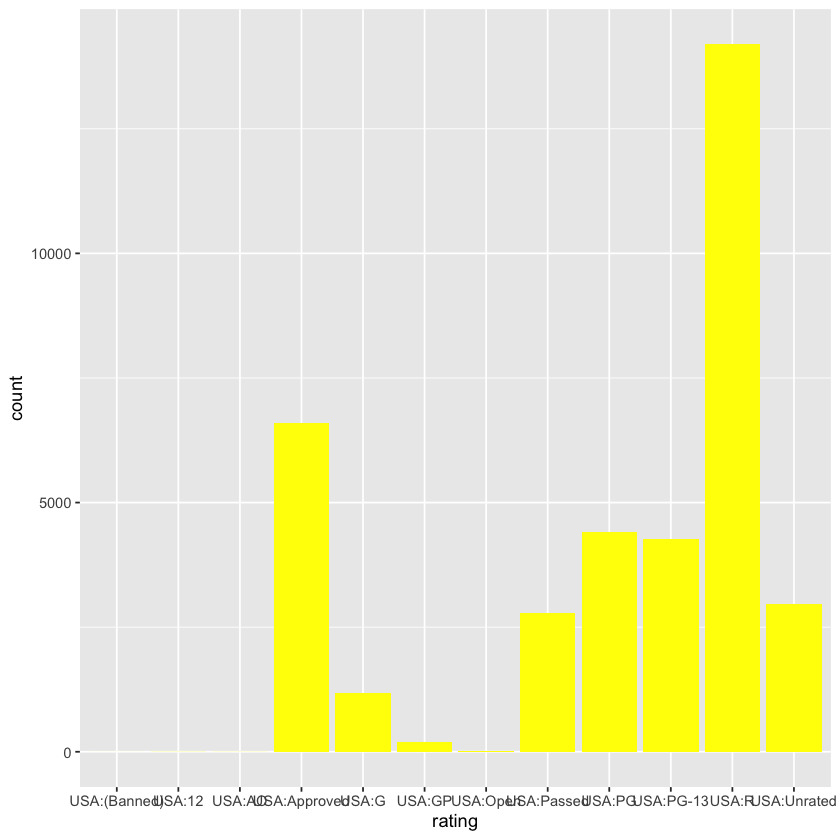

In [119]:
## Bar chart for distribution of certificates for a given movie ##

certificates_graph <- distribution_of_certificates(unique_movies)
ggplot(certificates_graph, aes(x = rating, y = count)) + geom_bar(stat = "identity", fill = "yellow")

In [141]:
## Bar chart for distribution of 10 key words ##
## Used ten as an example ## 

ten_keywords = distribution_of_keywords(unique_movies, 10)

ERROR: Error: Column `keyword` is unknown
